In [1]:
import torch
from torch.utils.data import DataLoader
from torch.nn import Linear, Conv2d

from torchvision.models import resnet18
from torchvision.transforms import v2

from src.classifier.utils.spike_to_img import AtisImageDataset

from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt

import seaborn as sns

import pandas as pd

import numpy as np

In [2]:
N_OUT = 3

WIDTH, HEIGHT = 76, 60

transform = v2.Compose([
    v2.RandomResizedCrop((HEIGHT, WIDTH), scale=(0.8, 1.0)),
    v2.RandomHorizontalFlip(),
])

dataset_train = AtisImageDataset('data/balanced_pruned/train_a_td.npy', 'data/balanced_pruned/train_a_bbox.npy', WIDTH, HEIGHT, transform=transform, dt_microsecs=100000.)
dataset_test = AtisImageDataset('data/balanced_pruned/test_a_td.npy', 'data/balanced_pruned/test_a_bbox.npy', WIDTH, HEIGHT, dt_microsecs=100000.)

dataloader_train = DataLoader(dataset_train, batch_size=32, shuffle=True)
dataloader_test = DataLoader(dataset_test, batch_size=32, shuffle=True)

In [3]:
N_RUNS = 1
N_EPOCHS = 30
LEARNING_RATE = 0.00003

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

val_acc = np.empty((N_RUNS, N_EPOCHS))

for i, run in enumerate(range(N_RUNS)):
    rsn = resnet18(pretrained=False)
    rsn.fc = Linear(512, N_OUT)
    rsn.conv1 = Conv2d(
        1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
    )

    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(rsn.parameters(), lr=LEARNING_RATE)

    rsn.to(device)

    print(f"Run {run}")
    for j, epoch in enumerate(range(N_EPOCHS)):
        rsn.train()
        for k, (images, labels) in enumerate(dataloader_train):
            images = images.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = rsn(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # if k % 100 == 0:
            #    print(f'Epoch {epoch}, step {k}, loss: {loss.item()}')

        rsn.eval()

        with torch.no_grad():
            correct = 0
            total = 0
            for images, labels in dataloader_test:
                images = images.to(device)
                labels = labels.to(device)

                outputs = rsn(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

            val_acc[i, j] = correct / total

            print(f"Epoch {epoch}, accuracy: {correct / total}")

/home/fabian/miniconda3/lib/python3.11/site-packages/torch/cuda/__init__.py:141: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at /opt/conda/conda-bld/pytorch_1708025842427/work/c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0
/home/fabian/miniconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/fabian/miniconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Run 0


KeyboardInterrupt: 

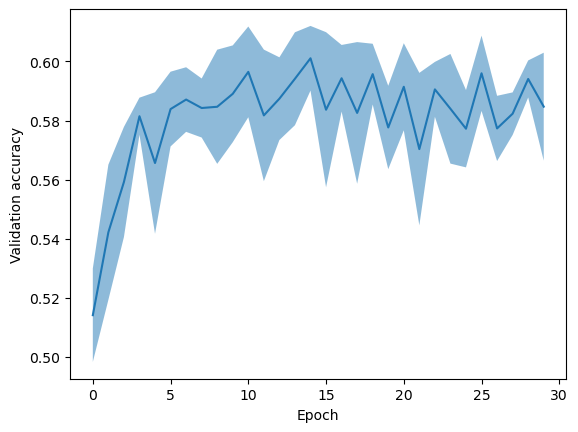

In [86]:
plt.plot(val_acc.mean(axis=0))
plt.fill_between(
    range(N_EPOCHS),
    val_acc.mean(axis=0) - val_acc.std(axis=0),
    val_acc.mean(axis=0) + val_acc.std(axis=0),
    alpha=0.5
)
plt.xlabel('Epoch')
plt.ylabel('Validation accuracy')

#plt.ylim(bottom=0.)

plt.show()

In [36]:
labels_test = np.empty(0)
preds_test = np.empty(0)

rsn.eval()
with torch.no_grad():
    for images, labels in dataloader_test:
        images = images.to(device)
        labels = labels.to(device)

        outputs = rsn(images)
        _, predicted = torch.max(outputs.data, 1)

        labels_test = np.concatenate((labels_test, labels.cpu().numpy()))
        preds_test = np.concatenate((preds_test, predicted.cpu().numpy()))


In [49]:
label_map = ['Cars', 'Pedestrians', 'None']

labels_true_test = [label_map[int(i)] for i in labels_test]
labels_pred_test = [label_map[int(i)] for i in preds_test]

df_test = pd.DataFrame({'true': labels_true_test, 'predicted': labels_pred_test})

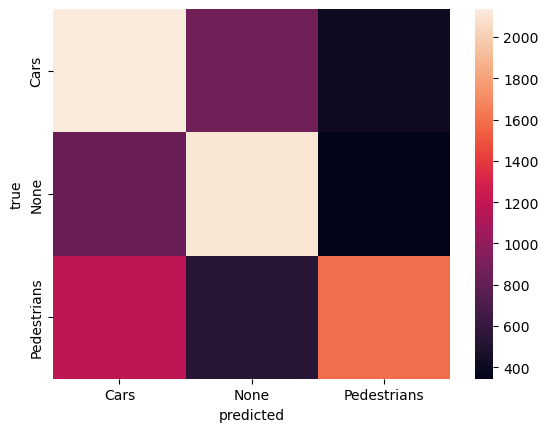

In [62]:
sns.heatmap(data=df_test.groupby(["true", "predicted"]).size().unstack(), vmin=0)
plt.show()

accuracy without pedestrians: 0.7140932816972554


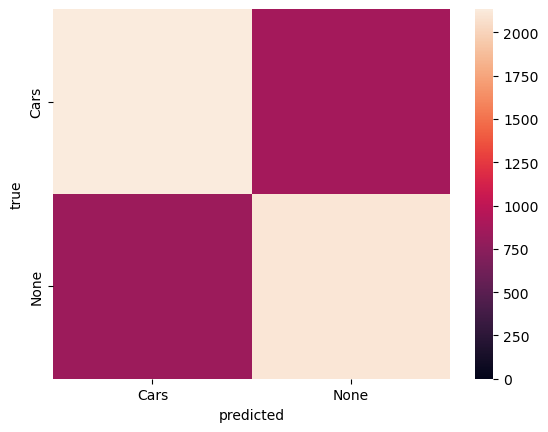

In [81]:
labels_test_without_pedestrians = labels_test[(labels_test != 1) & (preds_test != 1)]
preds_test_without_pedestrians = preds_test[(labels_test != 1) & (preds_test != 1)]

print("accuracy without pedestrians:", np.mean(labels_test_without_pedestrians == preds_test_without_pedestrians))

sns.heatmap(data=df_test[(df_test["true"]!="Pedestrians") & (df_test["predicted"] != "Pedestrians")].groupby(["true", "predicted"]).size().unstack(), vmin=0)
plt.show()

accuracy without none: 0.6994545796501787


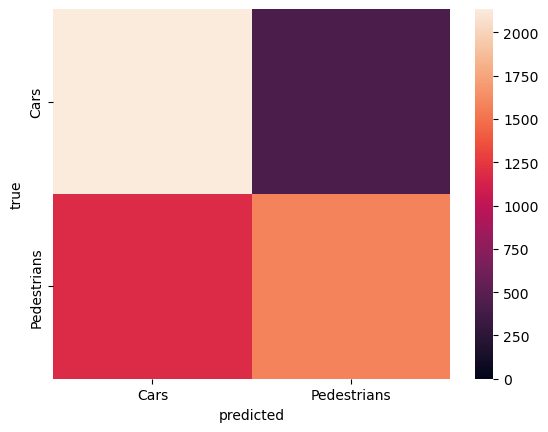

In [83]:
labels_test_without_none = labels_test[(labels_test != 2) & (preds_test != 2)]
preds_test_without_none = preds_test[(labels_test != 2) & (preds_test != 2)]

print("accuracy without none:", np.mean(labels_test_without_none == preds_test_without_none))

sns.heatmap(data=df_test[(df_test["true"]!="None") & (df_test["predicted"] != "None")].groupby(["true", "predicted"]).size().unstack(), vmin=0)
plt.show()

accuracy without cars: 0.8076165462902167


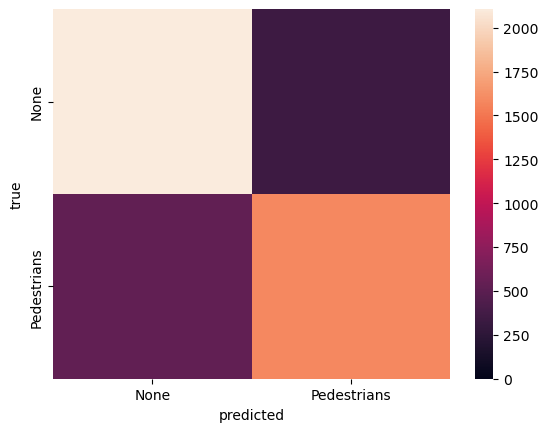

In [84]:
labels_test_without_cars = labels_test[(labels_test != 0) & (preds_test != 0)]
preds_test_without_cars = preds_test[(labels_test != 0) & (preds_test != 0)]

print("accuracy without cars:", np.mean(labels_test_without_cars == preds_test_without_cars))

sns.heatmap(data=df_test[(df_test["true"]!="Cars") & (df_test["predicted"] != "Cars")].groupby(["true", "predicted"]).size().unstack(), vmin=0)
plt.show()

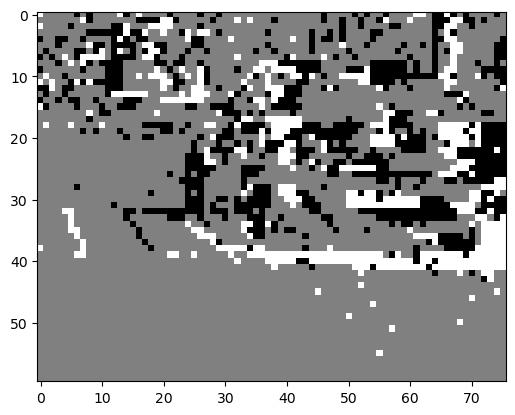

In [217]:

while True:
    idx = np.random.randint(len(dataset_test))
    img, label = dataset_test[idx]
    img = img.detach().cpu().numpy().squeeze()
    if label == 0:
        break

plt.imshow(img, cmap='gray')
plt.show()